In [3]:
import ee
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
ee.Authenticate()
ee.Initialize(project='ee-kmd232323')

In [5]:
import ee
ee.Initialize()


In [ ]:
# Load Maharashtra district shapefile
maha = ee.FeatureCollection("users/kmd232323/Maha_districts")

# Define years and months of interest
years = [2021, 2022]
months = range(5, 12)  # May to November

# Define band calculation functions
def addNDVI(image):
    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')
    return image.addBands(ndvi)

def addNDWI(image):
    ndwi = image.normalizedDifference(['sur_refl_b04', 'sur_refl_b02']).rename('NDWI')
    return image.addBands(ndwi)

def scaleLST(image):    
    lst_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(ee.Image.constant(273.15)).rename('LST')
    return image.addBands(lst_celsius)


    
# Get MODIS NDVI/NDWI
def get_ndvi_ndwi(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    return ee.ImageCollection("MODIS/061/MOD09GA") \
        .filterDate(start, end) \
        .filterBounds(maha) \
        .map(addNDVI).map(addNDWI) \
        .median() \
        .set('system:time_start', start.millis()) \
        .clip(maha)

# Get MODIS LST
def get_lst(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    return ee.ImageCollection("MODIS/061/MOD11A1") \
        .filterDate(start, end) \
        .filterBounds(maha) \
        .map(scaleLST) \
        .median() \
        .set('system:time_start', start.millis()) \
        .clip(maha)

# Get CHIRPS Rainfall
def get_rainfall(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    return ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate(start, end) \
        .filterBounds(maha) \
        .sum() \
        .rename("Rainfall") \
        .set('system:time_start', start.millis()) \
        .clip(maha)

# MAI = AET / PET; here we simulate with NDVI * Rainfall / PET
def calculate_mai(image):
    PET = ee.Number(100)  # Simulated constant PET, replace if actual PET is available
    mai = image.expression(
        '(ndvi * rain) / PET', {
            'ndvi': image.select('NDVI'),
            'rain': image.select('Rainfall'),
            'PET': PET
        }
    ).rename('MAI')
    return image.addBands(mai)

# SPI calculation
def calculate_spi(image):
    rainfall = image.select('Rainfall')
    mean_rainfall = rainfall.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=maha,
        scale=1000
    ).get('Rainfall')
    
    std_rainfall = rainfall.reduceRegion(
        reducer=ee.Reducer.stdDev(),
        geometry=maha,
        scale=1000
    ).get('Rainfall')
    
    spi = rainfall.subtract(ee.Image.constant(mean_rainfall)).divide(ee.Image.constant(std_rainfall)).rename('SPI')

    return image.addBands(spi)

# Define drought labels based on SPI

# Correct Drought Labeling based on SPI
def add_drought_label(image):
    spi = image.select('SPI')
    
    # Create masks
    drought_mask = spi.lt(-1)
    wet_mask = spi.gt(1)
    normal_mask = spi.gte(-1).And(spi.lte(1))
    
    # Assign labels
    drought_label = (
        drought_mask.multiply(1)  # Drought = 1
        .add(wet_mask.multiply(0))  # Wet merged into Normal = 0
        .add(normal_mask.multiply(0))  # Normal = 0
    ).rename('Drought_Label')
    
    return image.addBands(drought_label)



# Merge all bands from the same month and add drought label
def merge_features_with_labels(year, month):
    ndvi_ndwi = get_ndvi_ndwi(year, month)
    lst = get_lst(year, month)
    rainfall = get_rainfall(year, month)

    merged = lst.addBands(ndvi_ndwi.select(['NDVI', 'NDWI'])) \
                .addBands(rainfall.select('Rainfall')) \
                .set('system:time_start', lst.get('system:time_start'))

    merged_with_mai = calculate_mai(merged)
    merged_with_spi = calculate_spi(merged_with_mai)  # Add SPI calculation
    merged_with_labels = add_drought_label(merged_with_spi)  # Add the drought labels
    
    return merged_with_labels

# Build image collection
merged_images = [merge_features_with_labels(y, m) for y in years for m in months]
merged_collection = ee.ImageCollection(merged_images)

# Extract mean per district for each image
def extract_district_features(image):
    date = image.date().format("YYYY-MM-dd")
    stats = image.select(['NDVI', 'NDWI', 'LST', 'Rainfall', 'MAI', 'SPI', 'Drought_Label']) \
        .reduceRegions(
            collection=maha,
            reducer=ee.Reducer.mean(),
            scale=1000
        ).map(lambda f: f.set('date', date).set('NAME_2', f.get('NAME_2')))
    return stats

district_stats = merged_collection.map(extract_district_features).flatten()

# Export to Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=district_stats,
    description='Maha_Drought_Features_with_labels',
    fileFormat='CSV'
)
task.start()

print("✅ Export started! Monitor it in the Earth Engine Tasks tab.")


✅ Export started! Monitor it in the Earth Engine Tasks tab.


In [7]:
# Load your exported CSV
df = pd.read_csv('C:/Ketaki Dharmadhikari/Engineering/4th Year/Remote Sensing OEA/Maha_Drought_Features_with_labels.csv')

scaler = MinMaxScaler()
df['Rainfall_norm'] = scaler.fit_transform(df[['Rainfall']])

scaler = MinMaxScaler()
df['LST_norm'] = scaler.fit_transform(df[['LST']])

# List of columns to DROP
drop_cols = [
    'system:index', 'CC_2', 'COUNTRY', 'ENGTYPE_2', 'GID_0', 'GID_1', 'GID_2',
    'HASC_2', 'NAME_1', 'NL_NAME_1', 'NL_NAME_2', 'TYPE_2', 'VARNAME_2','Rainfall','LST'
]

# Drop unwanted columns
df_cleaned = df.drop(columns=drop_cols, errors='ignore')

# Save for visualization (keep .geo column)
df_cleaned.to_csv('district_drought_viz.csv', index=False)

# Save for ML modeling (remove .geo column)
df_model = df_cleaned.drop(columns=['.geo'], errors='ignore')
df_model.to_csv('district_drought_model.csv', index=False)

In [13]:
import pandas as pd

# Load your dataset
df = pd.read_csv('district_drought_model.csv')

# Merge Wet (2) into Normal (0)
df['Drought_Label'] = df['Drought_Label'].replace({2: 0})

# ✅ CHECK: Count the samples per class
print("Label distribution:\n", df['Drought_Label'].value_counts())


Label distribution:
 Drought_Label
0.000000    183
1.000000      3
0.009824      1
0.062704      1
0.638165      1
           ... 
0.187917      1
0.771804      1
0.427846      1
0.035677      1
0.154650      1
Name: count, Length: 320, dtype: int64


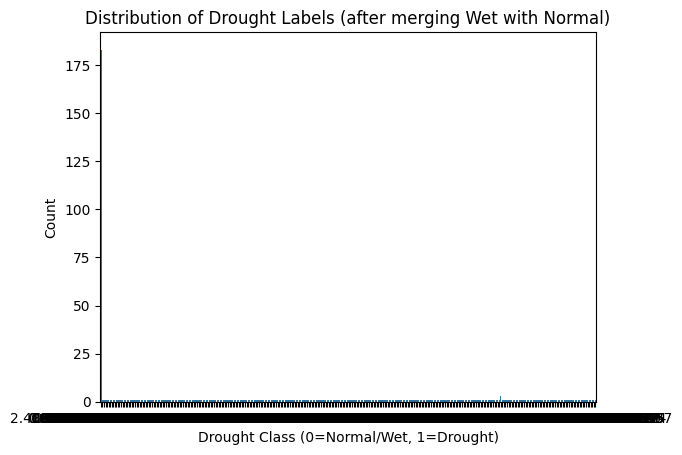

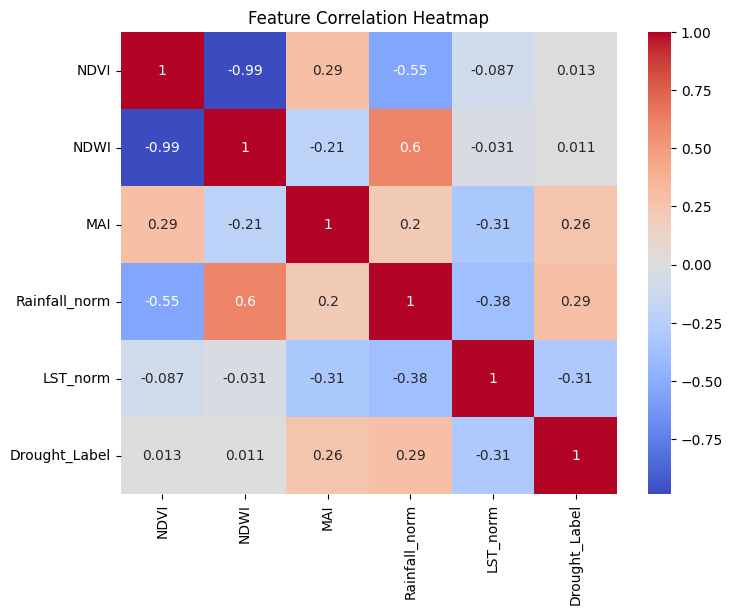

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('district_drought_model.csv')

# 🔥 Merge Wet (2) into Normal (0)
df['Drought_Label'] = df['Drought_Label'].replace({2: 0})

# Features and label
feature_cols = ['NDVI', 'NDWI', 'MAI', 'Rainfall_norm', 'LST_norm']
X = df[feature_cols]
y = df['Drought_Label']  # 0 = Normal/Wet, 1 = Drought

# ✨ Basic Visualization (after merging)

# 1. Distribution of Drought Labels
sns.countplot(x=y)
plt.title('Distribution of Drought Labels (after merging Wet with Normal)')
plt.xlabel('Drought Class (0=Normal/Wet, 1=Drought)')
plt.ylabel('Count')
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[feature_cols + ['Drought_Label']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# ✨ Model Training

# Split into train/test (now stratify works)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# ✨ Model Evaluation

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# ✨ Feature Importance Plot

importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# ✨ Save Prediction Results

# Predict full dataset
df['Predicted_Drought_Label'] = rf.predict(X)

# Save to CSV for dashboard use
df.to_csv('district_drought_predictions.csv', index=False)

print("✅ Predictions saved to district_drought_predictions.csv")
